In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import nd

import model_io_mx as model_io
import data_io

# from apply_heatmap import apply_colormap

from render import hm_to_rgb

na = np.newaxis

# LRP MX Convolution Demo

### 1) Load Data

In [2]:
Xtrain = data_io.read('../data/MNIST/train_images.npy')
Ytrain = data_io.read('../data/MNIST/train_labels.npy')

Xtest = data_io.read('../data/MNIST/test_images.npy')
Ytest = data_io.read('../data/MNIST/test_labels.npy')

#transfer the pixel values from [0 255] to [-1 1]
Xtrain = Xtrain / 127.5 -1
Xtest = Xtest / 127.5 -1

#transform numeric class labels to indicator vectors.
I = Ytrain[:,0].astype(int)
Ytrain = np.zeros([Xtrain.shape[0],np.unique(Ytrain).size])
Ytrain[np.arange(Ytrain.shape[0]),I] = 1

I = Ytest[:,0].astype(int)
Ytest = np.zeros([Xtest.shape[0],np.unique(Ytest).size])
Ytest[np.arange(Ytest.shape[0]),I] = 1

loading np-formatted data from ../data/MNIST/train_images.npy
loading np-formatted data from ../data/MNIST/train_labels.npy
loading np-formatted data from ../data/MNIST/test_images.npy
loading np-formatted data from ../data/MNIST/test_labels.npy


### 2) Load Model and Preprocess Data

In [3]:
# ctx = mx.cpu()
ctx = mx.gpu(0)

# load pre-trained model from txt file
lenet_model_path='../models/MNIST/LeNet-5.txt'
lenet = model_io.read(lenet_model_path, ctx=ctx)

# pad and reshape reshape convnet input and create mxnet ndarray:
Xtrain = Xtrain.reshape(-1, 28, 28,1)
Xtrain_padded = np.pad(Xtrain,((0,0),(2,2),(2,2),(0,0)), 'constant', constant_values = (-1.,))
Xtrain_mx = nd.array(Xtrain_padded, ctx=ctx)
Ytrain_mx = nd.array(Ytrain, ctx=ctx)

Xtest = Xtest.reshape(-1, 28, 28, 1)
Xtest_padded = np.pad(Xtest,((0,0),(2,2),(2,2),(0,0)), 'constant', constant_values = (-1.,))
Xtest_mx  = nd.array(Xtest_padded,  ctx=ctx)
Ytest_mx  = nd.array(Ytest,  ctx=ctx)

loading plain text model from ../models/MNIST/LeNet-5.txt


### 3) Prediction and Explanation

In [26]:
num_images = 5
lrp_type  = 'epsilon'
lrp_param = .000001

target = -1 # < 0 means top class

input_batch = Xtrain_mx[0:num_images]

# forward pass and lrp calculation
strt        = time.time()
predictions = lenet.forward(input_batch)

if target >=0:
    init_rel = ((nd.arange(10, ctx=ctx) == target) * 1.0).reshape((1, 10))
    init_rel = nd.broadcast_to(init_rel, (num_images, 10))
else:
    ranges       = nd.arange(10  , ctx=ctx)
    best_classes = nd.expand_dims(nd.argmax(predictions, axis=1), 1) * nd.ones((num_images, 10), ctx=ctx)
    init_rel = predictions * (ranges == best_classes)

relevance   = lenet.lrp(init_rel, lrp_type, lrp_param)

relevance.wait_to_read()

stp = time.time()

print('Calculated prediction and LRP scores for {} images in {}'.format(input_batch.shape[0], stp-strt))

Calculated prediction and LRP scores for 5 images in 1.12765312195


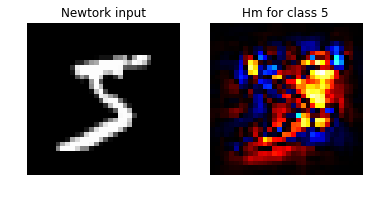

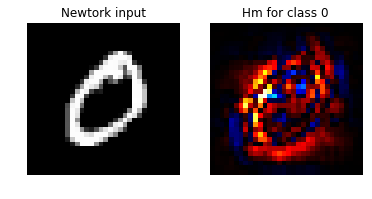

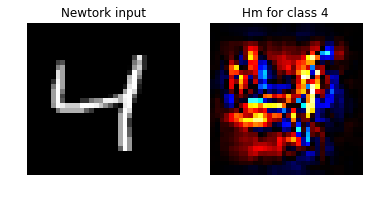

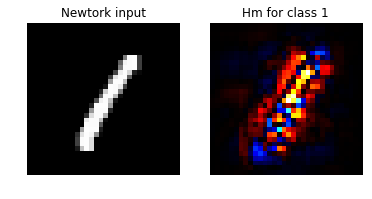

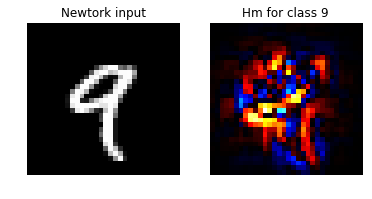

In [27]:
for i in range(num_images):
    # presentation
    plt.subplot(1,2,1)
    plt.imshow(Xtrain_mx[i].asnumpy().reshape(32, 32), cmap='gray', interpolation='none')
    plt.title('Newtork input')
    plt.axis('off')
    
    
    # process rawhm
    rawhm = relevance[i].asnumpy().reshape(32, 32)
    
    heatmap = hm_to_rgb(rawhm, cmap='black-firered')
    
    plt.subplot(1,2,2)
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title('Hm for class {}'.format(int(nd.argmax(init_rel, axis=1)[i].asnumpy()[0])))
    
    plt.show()